##### Import

In [ ]:
# Intallations with restart runtime requirement
!pip install pydeck

In [1]:
!pip install geopandas

In [2]:
# Mounting your personal Gdrive to the Colab notebook
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject

/gdrive/MyDrive/000 Spring 2022/ML/ML_FinalProject


In [4]:
import warnings
warnings.filterwarnings('ignore')

# Data
import pandas as pd
import numpy as np
import geopandas as gpd
import pickle

# sklearn
from sklearn.metrics import r2_score, mean_squared_error

# Visualization packages 
from matplotlib import pyplot as plt

import seaborn as sns
import wordcloud as wc
import missingno as msno

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

#import pydeck as pdk
from google.colab import output
output.enable_custom_widget_manager()

#### Read Data


In [148]:
df_full = pd.read_csv('data/fulldata_impute.csv')

#### Get Model Results

##### Scale Data

In [149]:
df_full = df_full[df_full['rolling_ton']<600]

In [150]:
var_binary = ['SD', 'C1', 'C2', 'C3', 'C4', 
              'pandemic', 'HeavyPre', 'Snow']

var_numeric = ['units_total', 
               #'number_rental_rooms','population_total',
       'residential_buildings', 'stairhalls',
       'total_sqft', 'acres', 
       'net_dev_sqft', 'acres_nopark',
       'nondev_sqft', 'park_acres', 
       'bldg_coverage_sqft', 
       'cubage_cuft', 
       'bldg_land_ratio', 
       'development_cost', 'cost_per_rental_room_ab', 
       'families_on_fixed_income', 'avg_m_gross_rent',
       'ave_r_per_unit', 
       'density_PopPerSqFt','density_PopPerDevFt', 'density_PopPerCubage',
        'per_unit_rb', 'per_capita_rb',
        'ave_height', 'ave_bldg_sqft',
        'Avg Temperature']

In [151]:
# Standardize numeric variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_full[var_numeric] = scaler.fit_transform(df_full[var_numeric].values)

In [73]:
df_model = df_full[df_full.time < '2021-09-01']
df_validation = df_full[df_full.time > '2021-08-01']

##### Remove Outlier

In [74]:
outlier = ['baruch', 'monterey', 'cassidylafayette', 'drewhamilton', 'careygardens', 'wyckoffgardens', 
           'morrisaniaairrights', 'redfern', 'baileyavenuewest193rdstreet', 'audubon', 'sheepsheadbay', 
           'campos', 'taylor', 'chelsea', 'seward']

In [75]:
df_model = df_model[~df_model['dsny_namecode'].isin(outlier)].reset_index(drop = True)
df_validation = df_validation[~df_validation['dsny_namecode'].isin(outlier)].reset_index(drop = True)

In [61]:
df_model.shape

(6148, 72)

In [62]:
df_validation.shape

(222, 72)

##### Load Model

In [76]:
def get_model_results(model_list, filepath, X_t, X_v, y_t, y_v):
  train_score = []
  pred_score = []
  train_MSE = []
  pred_MSE = []
  pred_train = []
  pred_validation = []

  for modelname in model_list:
    model = pickle.load(open(filepath+modelname+'.sav', 'rb'))

    y_pred_train = model.predict(X_t)
    y_pred_validation = model.predict(X_v)

    train_score.append(model.score(X_t, y_t))
    pred_score.append(model.score(X_v, y_v))
    train_MSE.append(mean_squared_error(y_t, y_pred_train))
    pred_MSE.append(mean_squared_error(y_v, y_pred_validation))
    pred_train.append(y_pred_train)
    pred_validation.append(y_pred_validation)

  summary = pd.DataFrame({'model':model_list,
                'R2_train': train_score,
                'R2_pred':pred_score,
                'MSE_train': train_MSE,
                'MSE_pred': pred_MSE})

  col_train = [n+'_train' for n in model_list]
  results_1 = pd.DataFrame(np.array(pred_train).T,
                        columns= col_train)

  col_val = [n+'_val' for n in model_list]
  results_2 = pd.DataFrame(np.array(pred_validation).T, columns= col_val)

  return(summary, results_1, results_2)

In [77]:
X_train = df_model[var_numeric+var_binary]
X_validation = df_validation[var_numeric+var_binary]
y_train = df_model['rolling_ton']
y_validation = df_validation['rolling_ton']

filepath_f = 'models/Full_Dataset/'
models = ['OLS', 'Lasso', 'DT', 'RF', 'GBRT']

s_full, r_t_full, r_v_full = get_model_results(model_list=models, filepath=filepath_f, 
                                X_t = X_train, X_v = X_validation,
                                y_t = y_train, y_v = y_validation)

In [78]:
X_train = df_model[var_numeric+var_binary]
X_validation = df_validation[var_numeric+var_binary]
y_train = df_model['rolling_ton']
y_validation = df_validation['rolling_ton']

filepath_o = 'models/Dataset_without_Outlier/'

s_woutlier, r_t_woutlier, r_v_woutlier = get_model_results(model_list=models, filepath=filepath_o, 
                                X_t = X_train, X_v = X_validation,
                                y_t = y_train, y_v = y_validation)

In [ ]:
df_validation['pandemic'] = 0

In [ ]:
X_train = df_model[var_numeric + var_binary]
X_validation = df_validation[var_numeric + var_binary]
y_train = df_model['rolling_ton']
y_validation = df_validation['rolling_ton']

filepath = '/gdrive/MyDrive/000 Spring 2022/Thesis Capstone/Data/Models/Full/'
full_models = ['Lasso', 'DT', 'RF', 'GBR']

s_full_1, r_t_full_1, r_v_full_1 = get_model_results(model_list=full_models, filepath=filepath, 
                                X_t = X_train, X_v = X_validation,
                                y_t = y_train, y_v = y_validation)

## Results Visualization

##### R2 Comparison

In [79]:
s_full

,model,R2_train,R2_pred,MSE_train,MSE_pred
0,OLS,0.853096,0.814778,341.977556,383.985788
1,Lasso,0.853047,0.814755,342.092363,384.034319
2,DT,0.950858,0.854434,114.397333,301.775765
3,RF,0.973859,0.921103,60.854717,163.563123
4,GBRT,0.966100,0.914613,78.916707,177.017445


In [80]:
s_woutlier

,model,R2_train,R2_pred,MSE_train,MSE_pred
0,OLS,0.854131,0.774491,339.567466,467.505802
1,Lasso,0.848766,0.777879,352.056840,460.482328
2,DT,0.805436,0.753983,452.926315,510.022734
3,RF,0.900683,0.823468,231.200887,365.970280
4,GBRT,0.893140,0.802912,248.758712,408.585619


In [31]:
table_1 = s_full[['model', 'R2_pred']].merge(s_woutlier[['model','R2_pred' ]], on = 'model', how = 'left')
table_1.columns = ['R2', 'Full Dataset', 'No Outlier']

In [32]:
table_1

,R2,Full Dataset,No Outlier
0,OLS,0.814712,0.774377
1,Lasso,0.814690,0.777763
2,DT,0.853514,0.753983
3,RF,0.921390,0.822339
4,GBRT,0.912851,0.819486


Comparison shows that Random Forest model trained using the full data set has the best performance. 

##### Compare the RF model performance for different consolidations

In [152]:
model = pickle.load(open('models/Full_Dataset/RF.sav', 'rb'))

X_train = df_full[var_numeric + var_binary]
y_train = df_full['rolling_ton']

y_pred_train = model.predict(X_train)

train_score = model.score(X_train, y_train)
train_MSE = mean_squared_error(y_train, y_pred_train)

In [153]:
df_full = pd.concat([df_full.reset_index(drop = True), pd.Series(np.array(y_pred_train).T)], axis = 1)
df_full = df_full.rename(columns = {0:'RF'})

In [155]:
df_full['RF_diff'] = df_full['rolling_ton']- df_full['RF']
df_full['RF_diff_abs'] = np.abs(df_full['RF_diff'])

In [175]:
df_5Ymean = df_full[['dsny_namecode', 'mean_ton']].groupby('dsny_namecode').mean().reset_index()

In [169]:
df_dev_diff = df_full.groupby('dsny_namecode').agg({'RF_diff_abs':'sum', 
                                      'RF_diff':'std', 'time':'count'}).reset_index()
df_dev_diff.columns = ['dsny_namecode', 'total_abs_diff', 'std_of_diff', 'number_month']
df_dev_diff['monthly_abs_diff'] =df_dev_diff.total_abs_diff/df_dev_diff.number_month

In [176]:
df_dev_diff = df_dev_diff.merge(df_5Ymean, how = 'left', on = 'dsny_namecode')

In [178]:
df_dev_diff['pct_monthly_abs_diff'] = df_dev_diff['monthly_abs_diff']/df_dev_diff['mean_ton']

In [192]:
df_dev_diff['pct_monthly_std'] = df_dev_diff['std_of_diff']/df_dev_diff['mean_ton']

In [177]:
df_dev_diff.head()

,dsny_namecode,total_abs_diff,std_of_diff,number_month,monthly_abs_diff,mean_ton
0,adams,163.328432,3.650690,57,2.865411,91.236382
1,albany,237.504375,5.247441,57,4.166743,105.273270
2,amsterdam,320.291753,6.288439,57,5.619154,89.628033
3,astoria,403.588198,10.722292,57,7.080495,111.359665
4,atlanticterminal,108.233570,2.339471,57,1.898835,24.947154


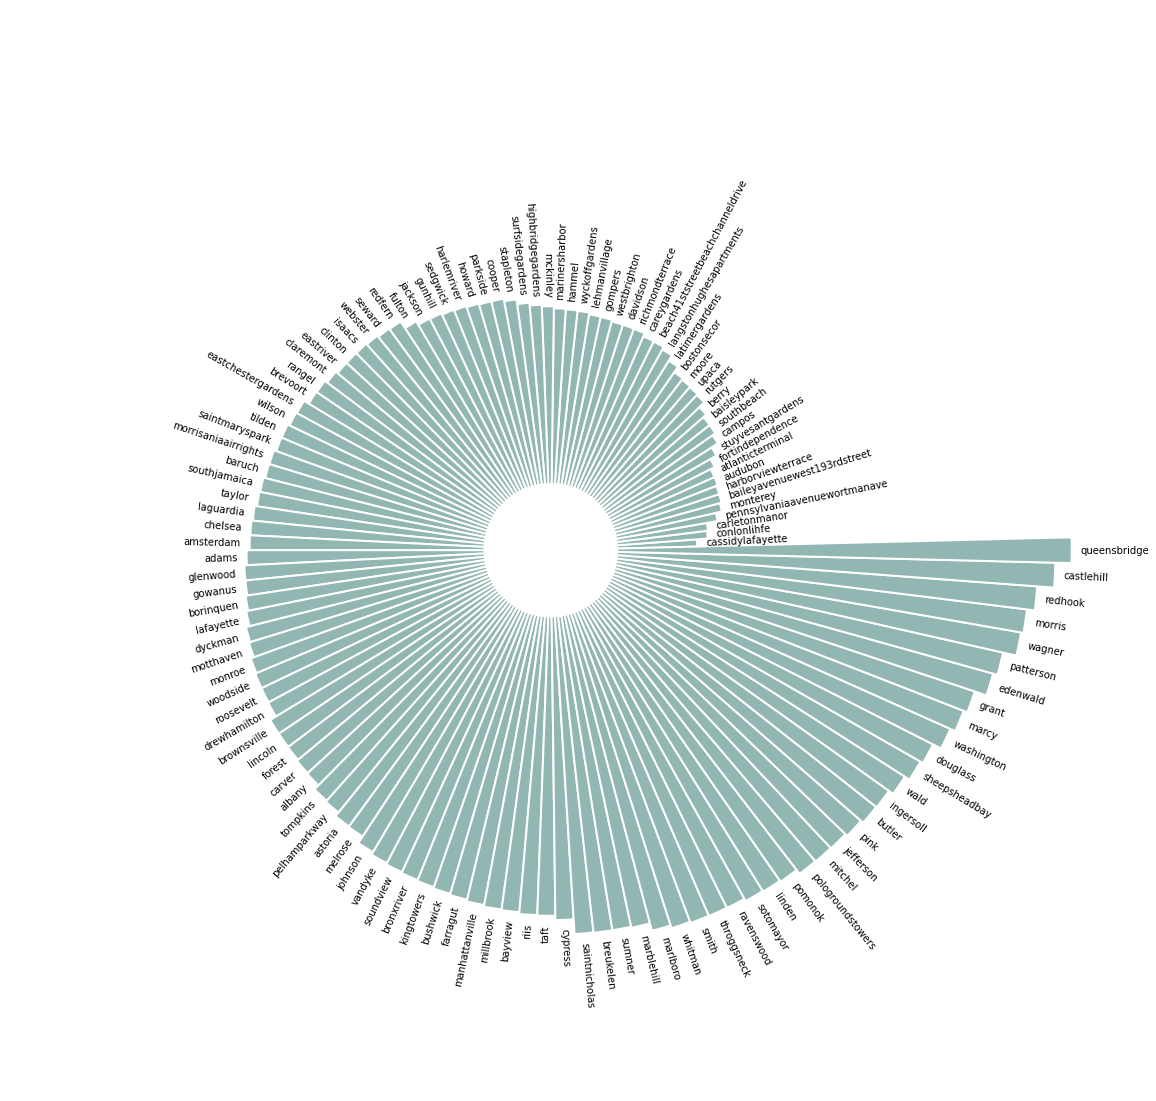

In [197]:
df_dev_diff = df_dev_diff.sort_values(by=['mean_ton'])

# initialize the figure
plt.figure(figsize=(20,20))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = df_dev_diff['mean_ton'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_dev_diff['mean_ton'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_dev_diff.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_dev_diff.index)+1))
angles = [element * width for element in indexes]
#angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#92B6B1",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_dev_diff["dsny_namecode"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")

plt.savefig('output/sitesize_bysize.png',  bbox_inches = 'tight', dpi = 600) 

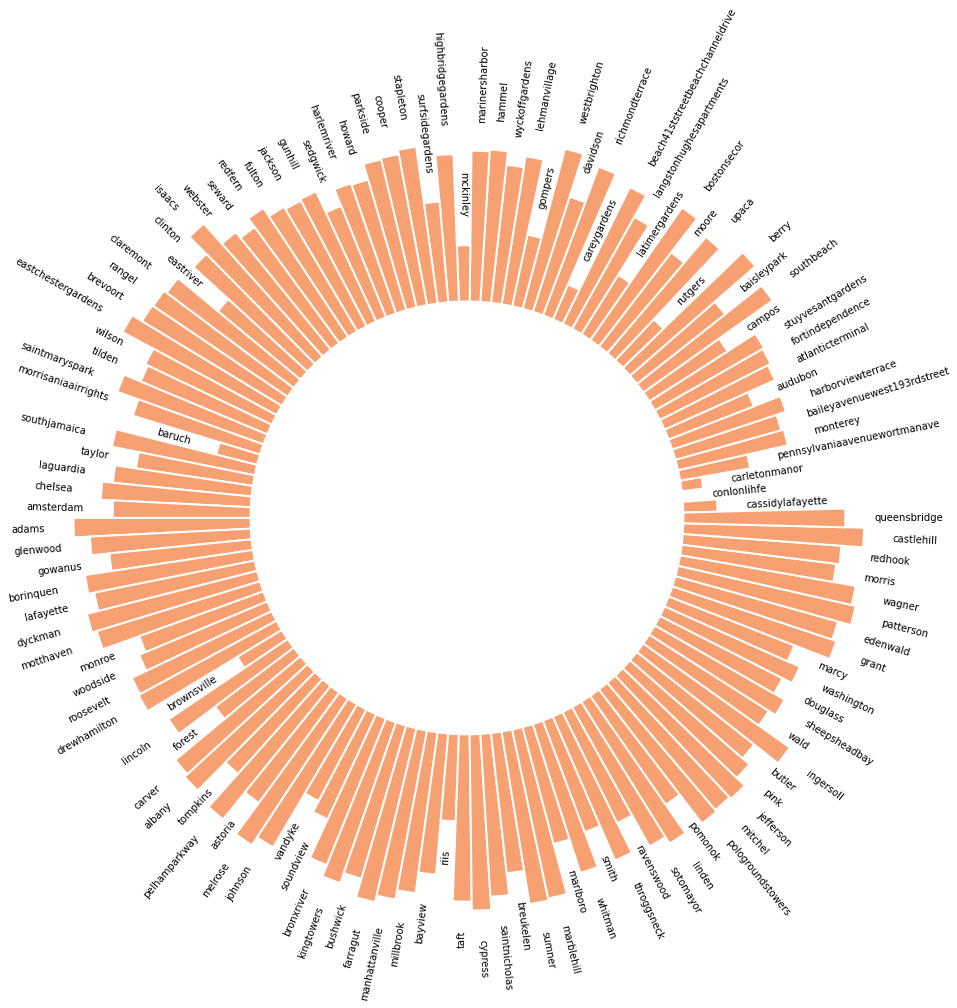

In [195]:
df_dev_diff = df_dev_diff.sort_values(by=['mean_ton'])

# initialize the figure
plt.figure(figsize=(15,15))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = df_dev_diff['pct_monthly_abs_diff'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_dev_diff['pct_monthly_abs_diff'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_dev_diff.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_dev_diff.index)+1))
angles = [element * width for element in indexes]
#angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#F7A072",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_dev_diff["dsny_namecode"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")
    
plt.savefig('output/monthlyabsdiff_persite.png', bbox_inches = 'tight', dpi = 600) 

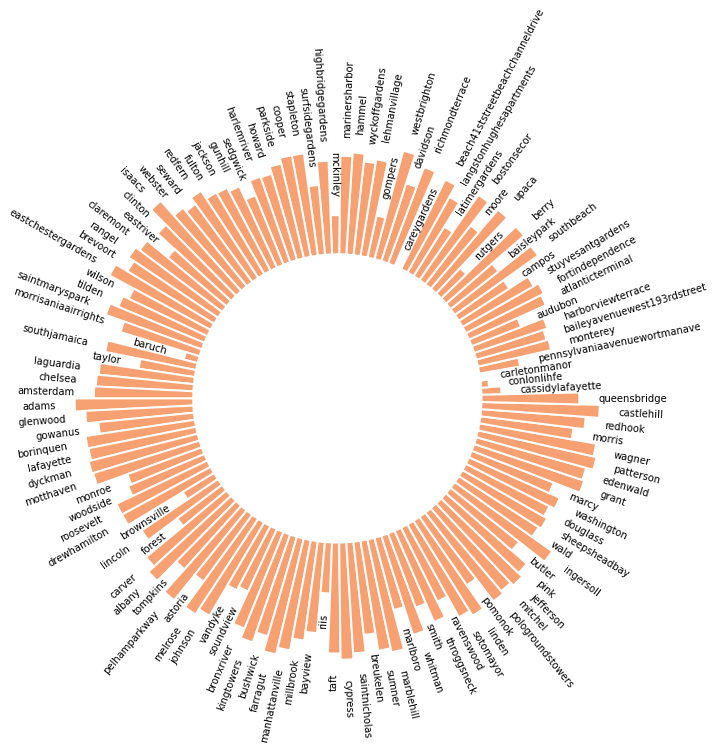

In [196]:
df_dev_diff = df_dev_diff.sort_values(by=['mean_ton'])

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Set the coordinates limits
upperLimit = 100
lowerLimit = 30

# Compute max and min in the dataset
max = df_dev_diff['pct_monthly_std'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_dev_diff['pct_monthly_std'] + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_dev_diff.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_dev_diff.index)+1))
angles = [element * width for element in indexes]
#angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#F7A072",
)

# little space between the bar and the label
labelPadding = 4

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_dev_diff["dsny_namecode"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")